In [1]:
import os
import csv
import re
import pickle
import random
import math
import dicom
import numpy as np
from tqdm import tqdm
from natsort import natsorted
from skimage import transform
from sklearn.externals import joblib
from scipy import ndimage

import matplotlib.pyplot as plt
%matplotlib inline

### explore and prepare data

In [2]:
study_folders = []
for folder in ['../../data/sunnybrook/challenge_online/challenge_online',
               '../../data/sunnybrook/challenge_training',
               '../../data/sunnybrook/challenge_validation']:
    study_folders.extend(natsorted([('-'.join(x.name.split('-')[:-1]) + '-' + x.name.split('-')[-1].zfill(2), 
                                     os.path.abspath(x.path)) for x in os.scandir(folder) if x.is_dir()]))

study_folders = natsorted(study_folders, lambda x: x[0])
len(study_folders)

45

In [3]:
contour_folders = []
for folder in ['../../data/sunnybrook/Sunnybrook Cardiac MR Database ContoursPart1/',
               '../../data/sunnybrook/Sunnybrook Cardiac MR Database ContoursPart2/',
               '../../data/sunnybrook/Sunnybrook Cardiac MR Database ContoursPart3/']:
    for root, dirs, files in os.walk(folder):
        if any([re.match(r'^SC-', study) for study in dirs]):
            contour_folders.extend(natsorted([(name, os.path.abspath('{}/{}'.format(root, name))) for name in dirs \
                                              if re.match(r'^SC-', name)]))

contour_folders = natsorted(contour_folders, lambda x: x[0])
len(contour_folders)

45

In [4]:
study_files = {}
for name, path in study_folders:
    study_files[name] = natsorted([(x.name, os.path.abspath(x.path)) for x in os.scandir(path) \
                                   if x.is_file() and re.search(r'\.dcm', x.name)])

In [5]:
contour_files = {}
for name, path in contour_folders:
    for root, dirs, files in os.walk(path):
        if any([re.search(r'contour-manual\.txt$', fname) for fname in files]):
            contour_files[name] = {}
            contour_files[name]['icontour'] = natsorted([(fname, os.path.abspath('{}/{}'.format(root, fname))) \
                                                         for fname in files if re.search(r'icontour-manual\.txt$', fname)])
            contour_files[name]['ocontour'] = natsorted([(fname, os.path.abspath('{}/{}'.format(root, fname))) \
                                                         for fname in files if re.search(r'ocontour-manual\.txt$', fname)])
            contour_files[name]['p1contour'] = natsorted([(fname, os.path.abspath('{}/{}'.format(root, fname))) \
                                                          for fname in files if re.search(r'p1contour-manual\.txt$', fname)])
            contour_files[name]['p2contour'] = natsorted([(fname, os.path.abspath('{}/{}'.format(root, fname))) \
                                                          for fname in files if re.search(r'p2contour-manual\.txt$', fname)])

All contour files have the format of IM-0001-XXXX-[i/o/p1/p2]contour-[auto/manual].txt
Because each study has multiple series, we have to match the series corersponding to the contour files

In [6]:
contour_files['SC-N-02']['icontour'][0]

('IM-0001-0020-icontour-manual.txt',
 '/home/leon/ML/kaggle/dsb/data/sunnybrook/Sunnybrook Cardiac MR Database ContoursPart3/TrainingDataContours/SC-N-02/contours-manual/IRCCI-expert/IM-0001-0020-icontour-manual.txt')

In [7]:
for fname, fpath in study_files['SC-N-02']:
    if re.match(r'IM-\d+-0020', fname):
        print(fname)

IM-0890-0020.dcm
IM-0891-0020.dcm
IM-0892-0020.dcm
IM-0897-0020.dcm
IM-0898-0020.dcm
IM-0902-0020.dcm


In [6]:
series_contour_match = {
    'SC-HF-I-01': '0004',
    'SC-HF-I-02': '0106',
    'SC-HF-I-04': '0116',
    'SC-HF-I-05': '0156',
    'SC-HF-I-06': '0180',
    'SC-HF-I-07': '0209',
    'SC-HF-I-08': '0226',
    'SC-HF-I-09': '0241',
    'SC-HF-I-10': '0024',
    'SC-HF-I-11': '0043',
    'SC-HF-I-12': '0062',
    'SC-HF-I-40': '0134',
    'SC-HF-NI-03': '0379',
    'SC-HF-NI-04': '0501',
    'SC-HF-NI-07': '0523',
    'SC-HF-NI-11': '0270',
    'SC-HF-NI-12': '0286',
    'SC-HF-NI-13': '0304',
    'SC-HF-NI-14': '0331',
    'SC-HF-NI-15': '0359',
    'SC-HF-NI-31': '0401',
    'SC-HF-NI-33': '0424',
    'SC-HF-NI-34': '0446',
    'SC-HF-NI-36': '0474',
    'SC-HYP-01': '0550',
    'SC-HYP-03': '0650',
    'SC-HYP-06': '0767',
    'SC-HYP-07': '0007',
    'SC-HYP-08': '0796',
    'SC-HYP-09': '0003',
    'SC-HYP-10': '0579',
    'SC-HYP-11': '0601',
    'SC-HYP-12': '0629',
    'SC-HYP-37': '0702',
    'SC-HYP-38': '0734',
    'SC-HYP-40': '0755',
    'SC-N-02': '0898',
    'SC-N-03': '0915',
    'SC-N-05': '0963',
    'SC-N-06': '0984',
    'SC-N-07': '1009',
    'SC-N-09': '1031',
    'SC-N-10': '0851',
    'SC-N-11': '0878',
    'SC-N-40': '0944'
}

In [7]:
def get_contour_coords(contour_fpath):
    with open(contour_fpath, 'r') as f:
        reader = csv.reader(f)
        return list([[float(xy) for xy in x[0].split()] for x in reader])

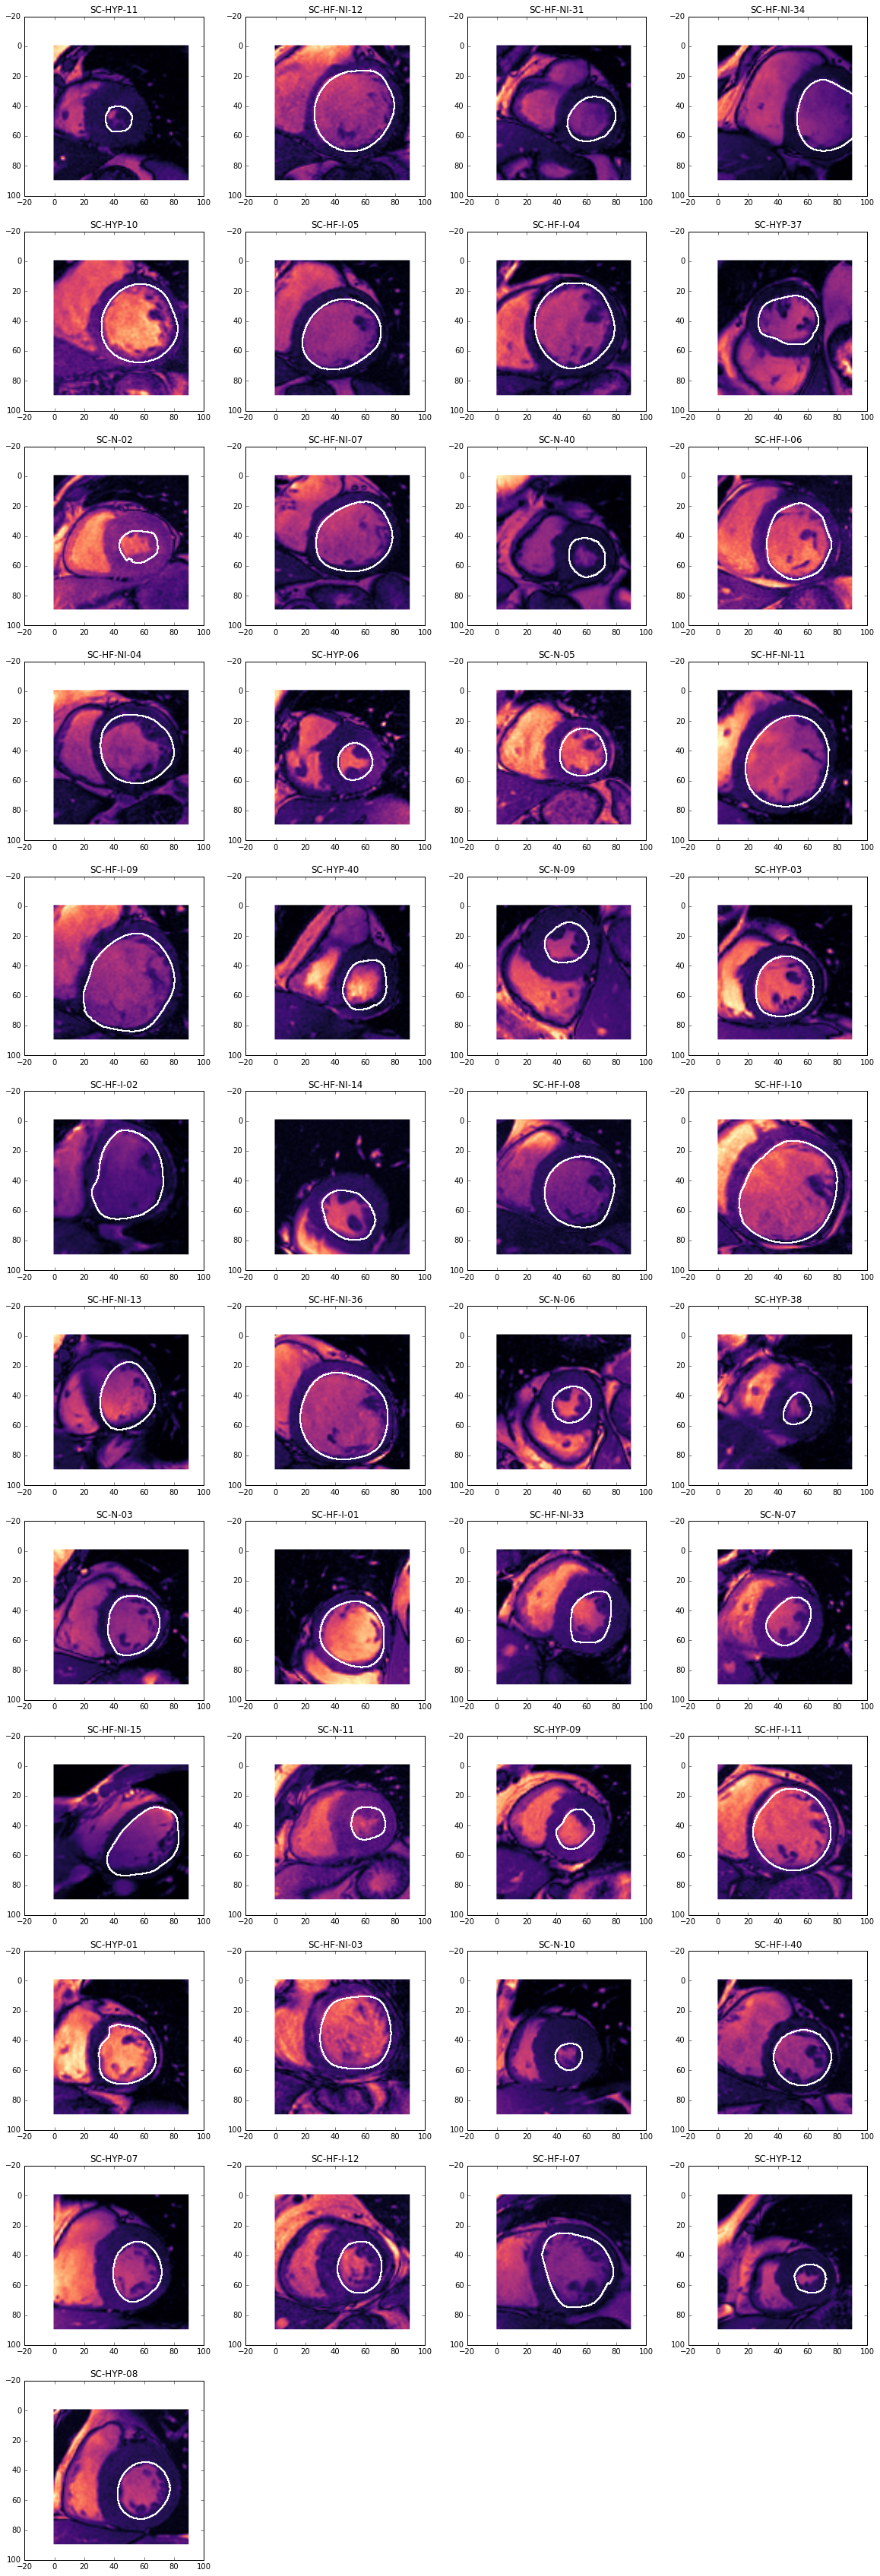

In [232]:
plt.figure(figsize=(20,60))

n = 0
for study_name in contour_files.keys():
    contour_fname, contour_fpath = contour_files[study_name]['icontour'][5]
    contour_coords = get_contour_coords(contour_fpath)
    try:
        n += 1
        for study_fname, study_fpath in study_files[study_name]:
            if re.compile('IM-{}-{}'.format(series_contour_match[study_name], contour_fname[8:12])).match(study_fname):
                break
        plt.subplot(12, 4, n)
        plt.title(study_name)
        plt.imshow(dicom.read_file(study_fpath).pixel_array[80:170,80:170], cmap=plt.cm.magma)
        for i in range(len(contour_coords) - 1):
            x0, y0 = contour_coords[i]
            x1, y1 = contour_coords[i+1]
            plt.plot([x0-80, x1-80], [y0-80, y1-80], 'w-', lw=2)
    except:
        print(study_name)

### create training data

In [8]:
def apply_window(arr, window_center, window_width):
    return np.clip(arr, window_center - window_width/2, window_center + window_width/2)

In [9]:
def apply_per_slice_norm(arr):
    mean = np.mean(arr.ravel())
    std = np.std(arr.ravel())
    if std == 0:
        return np.zeros(arr.shape)
    return (arr - mean) / std

In [10]:
def crop_to_square(arr, size):
    x_len, y_len = arr.shape
    shorter_len = min(x_len, y_len)
    x_start = (arr.shape[0] - shorter_len) // 2
    x_end = x_start + shorter_len
    y_start = (arr.shape[1] - shorter_len) // 2
    y_end = y_start + shorter_len
    return transform.resize(arr[x_start:x_end, y_start:y_end], 
                            (size, size), order=1, clip=True, preserve_range=True)

In [11]:
def get_matching_dicom(study_name, contour_fname):
    for study_fname, study_fpath in study_files[study_name]:
        if re.compile('IM-{}-{}'.format(series_contour_match[study_name], contour_fname[8:12])).match(study_fname):
            break
    return study_fname, study_fpath

In [12]:
def create_area_fill(contour_coords, img_shape):
    segment_mask = np.zeros(img_shape).astype(np.bool)
    for x, y in contour_coords:
        segment_mask[round(y), round(x)] = True
    segment_mask = ndimage.morphology.binary_fill_holes(segment_mask)
    return segment_mask

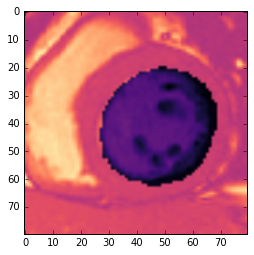

In [16]:
## test area fill function

study_name = 'SC-HYP-03'
contour_fname, contour_fpath = contour_files[study_name]['icontour'][3]
contour_coords = get_contour_coords(contour_fpath)

for study_fname, study_fpath in study_files[study_name]:
    if re.compile('IM-{}-{}'.format(series_contour_match[study_name], contour_fname[8:12])).match(study_fname):
        break
img = dicom.read_file(study_fpath).pixel_array
plt.imshow(img[90:170,80:160] - 500 * create_area_fill(contour_coords, img.shape)[90:170, 80:160], cmap=plt.cm.magma)

In [13]:
def split_img2d(img, mask, factor, nb):
    # assumes square shape
    newsize = img.shape[0] // factor
    splits = []
    for i in range(nb):
        rand_y = random.randint(0, img.shape[0] - newsize)
        rand_x = random.randint(0, img.shape[1] - newsize)
        splits.append((img[rand_y:(rand_y+newsize), rand_x:(rand_x+newsize)],
                       mask[rand_y:(rand_y+newsize), rand_x:(rand_x+newsize)]))
    return splits

In [14]:
def img_augmentation(img_full, img_half, img_quarter, mask_full, 
                     window_center, window_width, 
                     nb_samples, windowing=True, rotation=True, shift=True):
    
    aug_tuples = []
        
    for i in range(nb_samples):
    
        img_aug_full = img_full
        img_aug_half = img_half
        img_aug_quarter = img_quarter
        mask_aug_full = mask_full
        
        # windowing center +/- 50, window width +/- 100 with probability 0.5
        if windowing and random.random() > 0.5:
            rand_center = random.randrange(window_center-50, window_center+50)
            rand_width = random.randrange(window_width-100, window_width+100)
            img_aug_full = apply_window(img_aug_full, rand_center, rand_width)
            img_aug_half = apply_window(img_aug_half, rand_center, rand_width)
            img_aug_quarter = apply_window(img_aug_quarter, rand_center, rand_width)
            
        # shift +/- 0 to 0.25
        if shift:
            shift_y = round(0.25 * random.randrange(-img_full.shape[0], img_full.shape[0]))
            shift_x = round(0.25 * random.randrange(-img_full.shape[1], img_full.shape[1]))
            img_aug_full, mask_aug_full = (ndimage.interpolation.shift(img_aug_full, (shift_y, shift_x), 
                                                                       order=0, mode='constant'),
                                           ndimage.interpolation.shift(mask_aug_full, (shift_y, shift_x), 
                                                                       order=0, mode='constant'))
            img_aug_half = ndimage.interpolation.shift(img_aug_half, (shift_y // 2, shift_x // 2), 
                                                       order=0, mode='constant')
            img_aug_quarter = ndimage.interpolation.shift(img_aug_quarter, (shift_y // 4, shift_x // 4), 
                                                          order=0, mode='constant')
    
        # rotation +/- 0 to 60 degrees with probability 0.5
        if rotation and random.random() > 0.5:
            angle = random.randrange(-60, 60)
            img_aug_full, mask_aug_full = (ndimage.interpolation.rotate(img_aug_full, angle, axes=(0, 1), 
                                                                        order=0, mode='constant', reshape=False),
                                           ndimage.interpolation.rotate(mask_aug_full, angle, axes=(0, 1), 
                                                                        order=0, mode='constant', reshape=False))
            img_aug_half = ndimage.interpolation.rotate(img_aug_half, angle, axes=(0, 1), 
                                                        order=0, mode='constant', reshape=False)
            img_aug_quarter = ndimage.interpolation.rotate(img_aug_quarter, angle, axes=(0, 1), 
                                                           order=0, mode='constant', reshape=False)
        
        aug_tuples.append((img_aug_full, img_aug_half, img_aug_quarter, mask_aug_full))
        
    return aug_tuples

In [22]:
validation_studies = random.sample(list(contour_files.keys()), 5)
training_studies = [study for study in list(contour_files.keys()) if study not in validation_studies]

In [23]:
print('validation:', validation_studies)
print('training:', training_studies)

validation: ['SC-HF-NI-03', 'SC-HF-I-09', 'SC-HYP-06', 'SC-N-11', 'SC-HYP-03']
training: ['SC-HF-NI-36', 'SC-HYP-07', 'SC-HF-NI-04', 'SC-HF-NI-15', 'SC-HF-NI-13', 'SC-HF-NI-12', 'SC-HF-NI-07', 'SC-HF-I-40', 'SC-N-02', 'SC-HF-I-01', 'SC-HYP-11', 'SC-HYP-08', 'SC-HF-NI-14', 'SC-HF-I-04', 'SC-N-40', 'SC-HYP-38', 'SC-HYP-09', 'SC-HF-I-11', 'SC-HYP-12', 'SC-N-06', 'SC-HF-NI-33', 'SC-HYP-01', 'SC-HF-I-10', 'SC-HF-I-06', 'SC-HF-NI-31', 'SC-HF-I-05', 'SC-HF-NI-34', 'SC-N-05', 'SC-N-07', 'SC-HF-I-02', 'SC-HYP-37', 'SC-HF-NI-11', 'SC-HYP-10', 'SC-HF-I-08', 'SC-N-09', 'SC-N-10', 'SC-HF-I-12', 'SC-HF-I-07', 'SC-N-03', 'SC-HYP-40']


In [32]:
data_full_training = []
data_half_training = []
data_quarter_training = []
labels_full_training = []

data_full_validation = []
data_half_validation = []
data_quarter_validation = []
labels_full_validation = []

full_size = 256
half_size = full_size // 2
quarter_size = full_size // 4

for study_name in tqdm(contour_files.keys()):
    for contour_fname, contour_fpath in contour_files[study_name]['icontour']:
        contour_coords = get_contour_coords(contour_fpath)
        study_fname, study_fpath = get_matching_dicom(study_name, contour_fname)
        df = dicom.read_file(study_fpath)
        img = df.pixel_array
        mask = create_area_fill(contour_coords, img.shape)
        
        img_processed_full = crop_to_square(img, full_size)
        img_processed_half = crop_to_square(img, half_size)
        img_processed_quarter = crop_to_square(img, quarter_size)
        mask_processed_full = crop_to_square(mask, full_size)
        
        for (img_aug_full, img_aug_half, img_aug_quarter, mask_aug_full) \
            in img_augmentation(img_processed_full, img_processed_half, img_processed_quarter, mask_processed_full, 
                                df.WindowCenter, df.WindowWidth,
                                50, windowing=True, rotation=True, shift=True):
            
            img_aug_full = apply_per_slice_norm(img_aug_full)
            img_aug_half = apply_per_slice_norm(img_aug_half)
            img_aug_quarter = apply_per_slice_norm(img_aug_quarter)
        
            if study_name in training_studies:
                data_full_training.append(np.expand_dims(img_aug_full, axis=0))
                data_half_training.append(np.expand_dims(img_aug_half, axis=0))
                data_quarter_training.append(np.expand_dims(img_aug_quarter, axis=0))
                labels_full_training.append(mask_aug_full)
            elif study_name in validation_studies:
                data_full_validation.append(np.expand_dims(img_aug_full, axis=0))
                data_half_validation.append(np.expand_dims(img_aug_half, axis=0))
                data_quarter_validation.append(np.expand_dims(img_aug_quarter, axis=0))
                labels_full_validation.append(mask_aug_full)
            
data_full_training = np.array(data_full_training).astype(np.float32)
data_half_training = np.array(data_half_training).astype(np.float32)
data_quarter_training = np.array(data_quarter_training).astype(np.float32)
labels_full_training = np.array(labels_full_training).astype(np.bool)
data_full_validation = np.array(data_full_validation).astype(np.float32)
data_half_validation = np.array(data_half_validation).astype(np.float32)
data_quarter_validation = np.array(data_quarter_validation).astype(np.float32)
labels_full_validation = np.array(labels_full_validation).astype(np.bool)

print(data_full_training.shape, data_half_training.shape, data_quarter_training.shape, labels_full_training.shape)
print(data_full_validation.shape, data_half_validation.shape, data_quarter_validation.shape, labels_full_validation.shape)

(35700, 1, 256, 256) (35700, 1, 128, 128) (35700, 1, 64, 64) (35700, 256, 256)
(4550, 1, 256, 256) (4550, 1, 128, 128) (4550, 1, 64, 64) (4550, 256, 256)


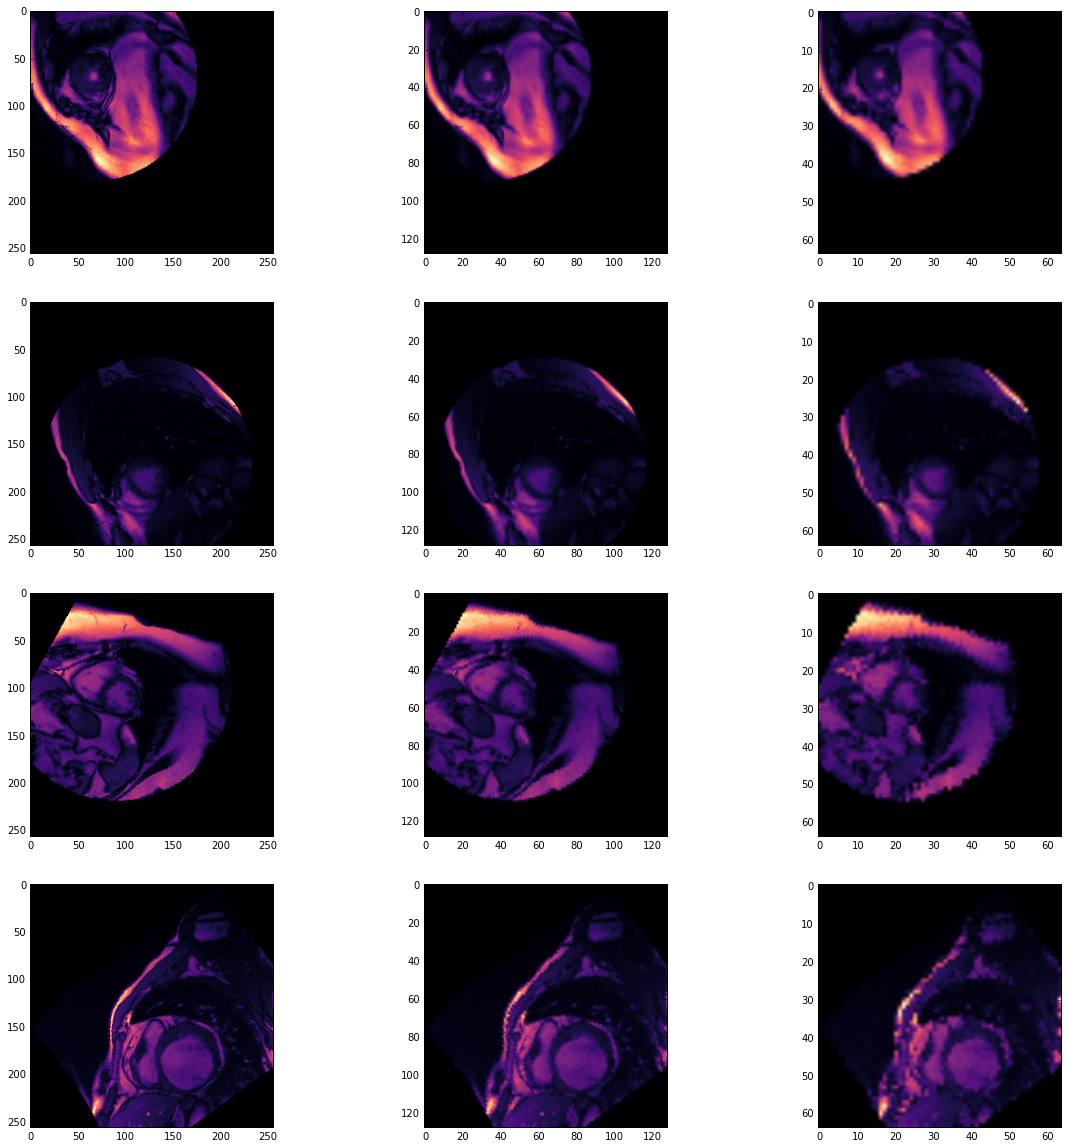

In [33]:
plt.figure(figsize=(20,20))
for i in range(4):
    n = random.randint(0, data_full_training.shape[0])
    plt.subplot(4,3,3*i+1)
    plt.imshow(data_full_training[n,0,:,:], cmap=plt.cm.magma)
    plt.subplot(4,3,3*i+2)
    plt.imshow(data_half_training[n,0,:,:], cmap=plt.cm.magma)
    plt.subplot(4,3,3*i+3)
    plt.imshow(data_quarter_training[n,0,:,:], cmap=plt.cm.magma)

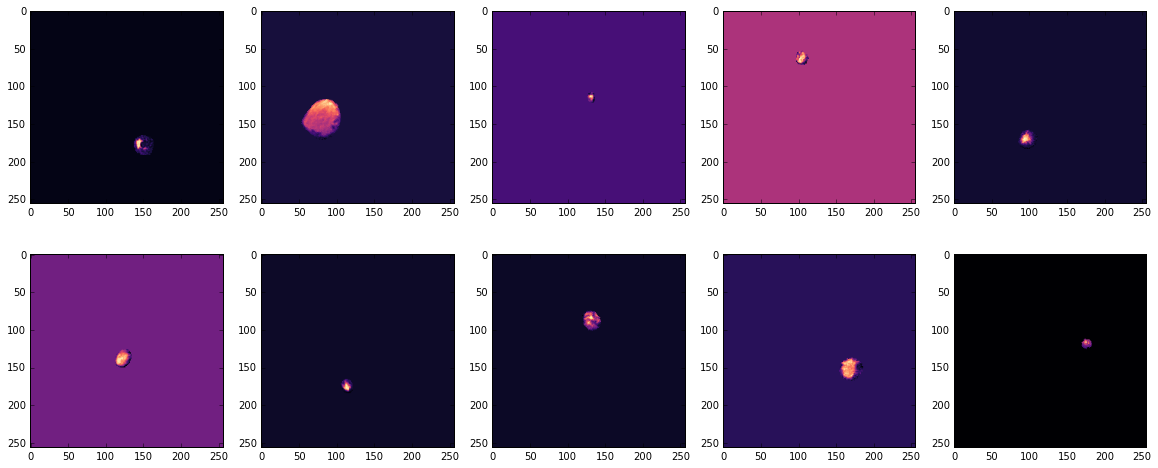

In [33]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    rand_i = random.randint(0,data_full_training.shape[0])
    plt.imshow(data_full_training[rand_i,0,:,:] * \
               labels_full_training[rand_i,:,:], cmap=plt.cm.magma)

In [34]:
shuffle_index = list(range(data_full_training.shape[0]))
random.shuffle(shuffle_index)
data_full_training = data_full_training[shuffle_index]
data_half_training = data_half_training[shuffle_index]
data_quarter_training = data_quarter_training[shuffle_index]
labels_full_training = labels_full_training[shuffle_index]

shuffle_index = list(range(data_full_validation.shape[0]))
random.shuffle(shuffle_index)
data_full_validation = data_full_validation[shuffle_index]
data_half_validation = data_half_validation[shuffle_index]
data_quarter_validation = data_quarter_validation[shuffle_index]
labels_full_validation = labels_full_validation[shuffle_index]

In [35]:
joblib.dump((validation_studies, training_studies,
             data_full_training, data_half_training, data_quarter_training, labels_full_training, 
             data_full_validation, data_half_validation, data_quarter_validation, labels_full_validation), 
            '../../data_proc/sunnybrook_segmentation_training_multires.pkl')

['../../data_proc/sunnybrook_segmentation_training_multires.pkl',
 '../../data_proc/sunnybrook_segmentation_training_multires.pkl_01.npy',
 '../../data_proc/sunnybrook_segmentation_training_multires.pkl_02.npy',
 '../../data_proc/sunnybrook_segmentation_training_multires.pkl_03.npy',
 '../../data_proc/sunnybrook_segmentation_training_multires.pkl_04.npy',
 '../../data_proc/sunnybrook_segmentation_training_multires.pkl_05.npy',
 '../../data_proc/sunnybrook_segmentation_training_multires.pkl_06.npy',
 '../../data_proc/sunnybrook_segmentation_training_multires.pkl_07.npy',
 '../../data_proc/sunnybrook_segmentation_training_multires.pkl_08.npy']

### training

In [15]:
from keras.models import Sequential, Graph
from keras.layers.core import Activation, Dense, Dropout, Flatten, Merge, Reshape, Lambda
from keras.layers.core import TimeDistributedDense, TimeDistributedMerge
from keras.layers.recurrent import LSTM, GRU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ParametricSoftplus, ELU
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout, GaussianNoise
from keras.utils import np_utils, generic_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using Theano backend.


Using gpu device 3: Tesla K80 (CNMeM is disabled)


In [16]:
(validation_studies, training_studies,
 data_full_training, data_half_training, data_quarter_training, labels_full_training, 
 data_full_validation, data_half_validation, data_quarter_validation, labels_full_validation) = \
    joblib.load('../../data_proc/sunnybrook_segmentation_training_multires.pkl')

In [17]:
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=None, keepdims=False))

def binaryCE(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=None, keepdims=False)

In [18]:
from keras import initializations
from keras.layers.core import Layer
from keras import backend as K


class Rotate90(Layer):
    def __init__(self, direction='clockwise', **kwargs):
        super(Rotate90, self).__init__(**kwargs)
        self.direction = direction

    def get_output(self, train):
        X = self.get_input(train)
        if self.direction == 'clockwise':
            return X.transpose((0, 2, 1))[:, :, ::-1]
        elif self.direction == 'counterclockwise':
            return X.transpose((0, 2, 1))[:, ::-1, :]
        else:
            raise

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Rotate90, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [19]:
model = Graph()

model.add_input(name='input_full', input_shape=(1, 256, 256))
model.add_input(name='input_half', input_shape=(1, 128, 128))
model.add_input(name='input_quarter', input_shape=(1, 64, 64))

model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-conv-1', input='input_full')
model.add_node(BatchNormalization(), name='full-bn-1', input='full-conv-1')
model.add_node(ELU(), name='full-activ-1', input='full-bn-1')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='full-pool-1', input='full-activ-1')
model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-conv-2', input='full-pool-1')
model.add_node(BatchNormalization(), name='full-bn-2', input='full-conv-2')
model.add_node(ELU(), name='full-activ-2', input='full-bn-2')
model.add_node(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='th'),
               name='full-pool-2', input='full-activ-2')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-conv-3', input='full-pool-2')
model.add_node(BatchNormalization(), name='full-bn-3', input='full-conv-3')
model.add_node(ELU(), name='full-activ-3', input='full-bn-3')
model.add_node(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='th'),
               name='full-pool-3', input='full-activ-3')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-conv-4', input='full-pool-3')
model.add_node(BatchNormalization(), name='full-bn-4', input='full-conv-4')
model.add_node(ELU(), name='full-activ-4', input='full-bn-4')
model.add_node(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='th'),
               name='full-pool-4', input='full-activ-4')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-conv-5', input='full-pool-4')
model.add_node(BatchNormalization(), name='full-bn-5', input='full-conv-5')
model.add_node(ELU(), name='full-activ-5', input='full-bn-5')
model.add_node(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='th'),
               name='full-pool-5', input='full-activ-5')
model.add_node(Flatten(), name='full-flatten', input='full-pool-5')
model.add_node(Dense(4096, activation='relu'), name='full-fc-1', input='full-flatten')
model.add_node(Dropout(0.5), name='full-dropout-1', input='full-fc-1')
model.add_node(Reshape((64, 8, 8)), name='full-reshape', input='full-dropout-1')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='full-unpool-1', input='full-reshape')
model.add_node(Convolution2D(256, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-deconv-1', input='full-unpool-1')
model.add_node(BatchNormalization(), name='full-bn-6', input='full-deconv-1')
model.add_node(ELU(), name='full-activ-6', input='full-bn-6')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='full-unpool-2', input='full-activ-6')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-deconv-2', input='full-unpool-2')
model.add_node(BatchNormalization(), name='full-bn-7', input='full-deconv-2')
model.add_node(ELU(), name='full-activ-7', input='full-bn-7')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='full-unpool-3', input='full-activ-7')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-deconv-3', input='full-unpool-3')
model.add_node(BatchNormalization(), name='full-bn-8', input='full-deconv-3')
model.add_node(ELU(), name='full-activ-8', input='full-bn-8')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='full-unpool-4', input='full-activ-8')
model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-deconv-4', input='full-unpool-4')
model.add_node(BatchNormalization(), name='full-bn-9', input='full-deconv-4')
model.add_node(ELU(), name='full-activ-9', input='full-bn-9')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='full-unpool-5', input='full-activ-9')
model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='full-deconv-5', input='full-unpool-5')
model.add_node(BatchNormalization(), name='full-bn-10', input='full-deconv-5')
model.add_node(ELU(), name='full-activ-10', input='full-bn-10')
model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='full-prob-map', input='full-activ-10')
model.add_node(Reshape((256, 256)), name='full-prob-map-reshape', input='full-prob-map')
model.add_node(Dropout(0.5), name='full-prob-map-dropout', input='full-prob-map-reshape')

model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='half-conv-1', input='input_half')
model.add_node(BatchNormalization(), name='half-bn-1', input='half-conv-1')
model.add_node(ELU(), name='half-activ-1', input='half-bn-1')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='half-pool-1', input='half-activ-1')
model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='half-conv-2', input='half-pool-1')
model.add_node(BatchNormalization(), name='half-bn-2', input='half-conv-2')
model.add_node(ELU(), name='half-activ-2', input='half-bn-2')
model.add_node(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='th'),
               name='half-pool-2', input='half-activ-2')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='half-conv-3', input='half-pool-2')
model.add_node(BatchNormalization(), name='half-bn-3', input='half-conv-3')
model.add_node(ELU(), name='half-activ-3', input='half-bn-3')
model.add_node(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='th'),
               name='half-pool-3', input='half-activ-3')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='half-conv-4', input='half-pool-3')
model.add_node(BatchNormalization(), name='half-bn-4', input='half-conv-4')
model.add_node(ELU(), name='half-activ-4', input='half-bn-4')
model.add_node(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='th'),
               name='half-pool-4', input='half-activ-4')
model.add_node(Flatten(), name='half-flatten', input='half-pool-4')
model.add_node(Dense(4096, activation='relu'), name='half-fc-1', input='half-flatten')
model.add_node(Dropout(0.5), name='half-dropout-1', input='half-fc-1')
model.add_node(Reshape((64, 8, 8)), name='half-reshape', input='half-dropout-1')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='half-unpool-1', input='half-reshape')
model.add_node(Convolution2D(128, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='half-deconv-1', input='half-unpool-1')
model.add_node(BatchNormalization(), name='half-bn-5', input='half-deconv-1')
model.add_node(ELU(), name='half-activ-5', input='half-bn-5')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='half-unpool-2', input='half-activ-5')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='half-deconv-2', input='half-unpool-2')
model.add_node(BatchNormalization(), name='half-bn-6', input='half-deconv-2')
model.add_node(ELU(), name='half-activ-6', input='half-bn-6')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='half-unpool-3', input='half-activ-6')
model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='half-deconv-3', input='half-unpool-3')
model.add_node(BatchNormalization(), name='half-bn-7', input='half-deconv-3')
model.add_node(ELU(), name='half-activ-7', input='half-bn-7')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='half-unpool-4', input='half-activ-7')
model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='half-deconv-4', input='half-unpool-4')
model.add_node(BatchNormalization(), name='half-bn-8', input='half-deconv-4')
model.add_node(ELU(), name='half-activ-8', input='half-bn-8')
model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='half-prob-map', input='half-activ-8')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='half-upsample', input='half-prob-map')
model.add_node(Reshape((256, 256)), name='half-prob-map-reshape', input='half-upsample')
model.add_node(Dropout(0.5), name='half-prob-map-dropout', input='half-prob-map-reshape')

model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='quarter-conv-1', input='input_quarter')
model.add_node(BatchNormalization(), name='quarter-bn-1', input='quarter-conv-1')
model.add_node(ELU(), name='quarter-activ-1', input='quarter-bn-1')
model.add_node(MaxPooling2D(pool_size=(2,2), strides=None, border_mode='valid', dim_ordering='th'),
               name='quarter-pool-1', input='quarter-activ-1')
model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='quarter-conv-2', input='quarter-pool-1')
model.add_node(BatchNormalization(), name='quarter-bn-2', input='quarter-conv-2')
model.add_node(ELU(), name='quarter-activ-2', input='quarter-bn-2')
model.add_node(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='th'),
               name='quarter-pool-2', input='quarter-activ-2')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='quarter-conv-3', input='quarter-pool-2')
model.add_node(BatchNormalization(), name='quarter-bn-3', input='quarter-conv-3')
model.add_node(ELU(), name='quarter-activ-3', input='quarter-bn-3')
model.add_node(MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='th'),
               name='quarter-pool-3', input='quarter-activ-3')
model.add_node(Flatten(), name='quarter-flatten', input='quarter-pool-3')
model.add_node(Dense(4096, activation='relu'), name='quarter-fc-1', input='quarter-flatten')
model.add_node(Dropout(0.5), name='quarter-dropout-1', input='quarter-fc-1')
model.add_node(Reshape((64, 8, 8)), name='quarter-reshape', input='quarter-dropout-1')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='quarter-unpool-1', input='quarter-reshape')
model.add_node(Convolution2D(64, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='quarter-deconv-1', input='quarter-unpool-1')
model.add_node(BatchNormalization(), name='quarter-bn-4', input='quarter-deconv-1')
model.add_node(ELU(), name='quarter-activ-4', input='quarter-bn-4')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='quarter-unpool-2', input='quarter-activ-4')
model.add_node(Convolution2D(32, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='quarter-deconv-2', input='quarter-unpool-2')
model.add_node(BatchNormalization(), name='quarter-bn-5', input='quarter-deconv-2')
model.add_node(ELU(), name='quarter-activ-5', input='quarter-bn-5')
model.add_node(UpSampling2D(size=(2, 2), dim_ordering='th'), name='quarter-unpool-3', input='quarter-activ-5')
model.add_node(Convolution2D(16, 3, 3, init='he_uniform', border_mode='same', dim_ordering='th'),
               name='quarter-deconv-3', input='quarter-unpool-3')
model.add_node(BatchNormalization(), name='quarter-bn-6', input='quarter-deconv-3')
model.add_node(ELU(), name='quarter-activ-6', input='quarter-bn-6')
model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='quarter-prob-map', input='quarter-activ-6')
model.add_node(UpSampling2D(size=(4, 4), dim_ordering='th'), name='quarter-upsample', input='quarter-prob-map')
model.add_node(Reshape((256, 256)), name='quarter-prob-map-reshape', input='quarter-upsample')
model.add_node(Dropout(0.5), name='quarter-prob-map-dropout', input='quarter-prob-map-reshape')

model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-we-1', inputs=['full-prob-map-dropout', 'half-prob-map-dropout', 'quarter-prob-map-dropout'],
               merge_mode='sum')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-we-2', input='rnn-we-1')
model.add_node(Reshape((1, 256, 256)), name='rnn-we-reshaped', input='rnn-we-2')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-ew-1', inputs=['full-prob-map-dropout', 'half-prob-map-dropout', 'quarter-prob-map-dropout'],
               merge_mode='sum')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-ew-2', input='rnn-ew-1')
model.add_node(Reshape((1, 256, 256)), name='rnn-ew-reshaped', input='rnn-ew-2')

model.add_node(Rotate90(direction='counterclockwise'),
               name='rotate', inputs=['full-prob-map-dropout', 'half-prob-map-dropout', 'quarter-prob-map-dropout'],
               merge_mode='sum')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-ns-1', input='rotate')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', return_sequences=True),
               name='rnn-ns-2-rotated', input='rnn-ns-1')
model.add_node(Rotate90(direction='clockwise'), name='rnn-ns-2', input='rnn-ns-2-rotated')
model.add_node(Reshape((1, 256, 256)), name='rnn-ns-reshaped', input='rnn-ns-2')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-sn-1', input='rotate')
model.add_node(GRU(256, activation='tanh', inner_activation='hard_sigmoid', go_backwards=True, return_sequences=True),
               name='rnn-sn-2-rotated', input='rnn-sn-1')
model.add_node(Rotate90(direction='clockwise'), name='rnn-sn-2', input='rnn-sn-2-rotated')
model.add_node(Reshape((1, 256, 256)), name='rnn-sn-reshaped', input='rnn-sn-2')

model.add_node(Activation('linear'),
               name='rnn-concat', inputs=['rnn-we-reshaped', 'rnn-ew-reshaped', 'rnn-ns-reshaped', 'rnn-sn-reshaped'],
               merge_mode='concat', concat_axis=-3)
model.add_node(Convolution2D(1, 1, 1, activation='sigmoid', init='uniform', border_mode='same', dim_ordering='th'),
               name='rnn-reduce', input='rnn-concat')
model.add_node(Reshape((256, 256)), name='pre-output', input='rnn-reduce')

model.add_output(name='output', input='pre-output')

model.compile('adam', {'output': binaryCE})

In [ ]:
batch_size = 64
nb_epoch = 10
    
checkpointer = ModelCheckpoint(filepath='../../model_weights/sunnybrook_segmentation_multires.hdf5', 
                               verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

model.fit({'input_full': data_full_training, 
           'input_half': data_half_training, 
           'input_quarter': data_quarter_training, 
           'output': labels_full_training}, 
          batch_size=batch_size, 
          nb_epoch=nb_epoch, 
          verbose=1,
          shuffle=True, 
          class_weight={'output': {0: 1, 1: 10}},
          validation_data={'input_full': data_full_validation, 
                           'input_half': data_half_validation, 
                           'input_quarter': data_quarter_validation, 
                           'output': labels_full_validation}, 
          callbacks=[checkpointer, earlystopping])

The above training code is run separately in a script.

### test segmentation

In [20]:
model.load_weights('../../model_weights/sunnybrook_segmentation_multires.hdf5')

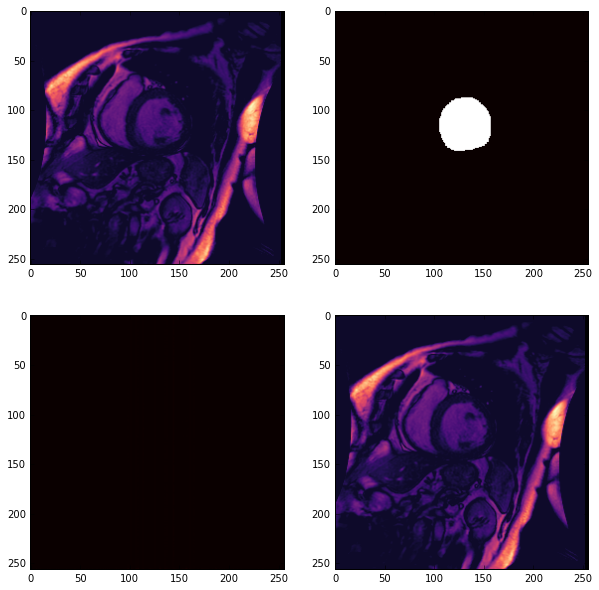

In [22]:
i = 15
img = data_full_validation[i,0,:,:]
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(img, cmap=plt.cm.magma)
plt.subplot(2,2,2)
plt.imshow(labels_full_validation[i,:,:], cmap=plt.cm.hot)

segmentation = model.predict({'input_full': data_full_validation[i:(i+1)], 
                              'input_half': data_half_validation[i:(i+1)], 
                              'input_quarter': data_quarter_validation[i:(i+1)]}, 
                             verbose=0)['output'][0]


plt.subplot(2,2,3)
plt.imshow(segmentation, cmap=plt.cm.hot)

plt.subplot(2,2,4)
plt.imshow(img * segmentation, cmap=plt.cm.magma)

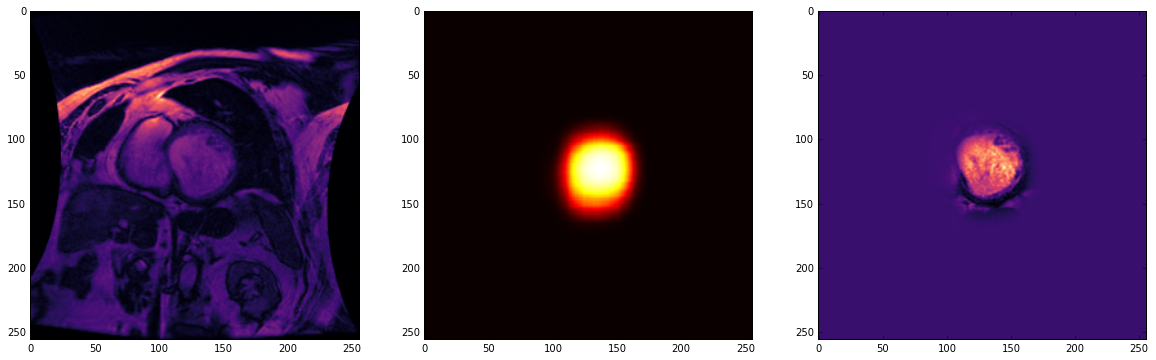

In [163]:
study_name = 'SC-HF-NI-04'
contour_fname, contour_fpath = contour_files[study_name]['icontour'][0]
for study_fname, study_fpath in study_files[study_name]:
    if re.compile('IM-{}-{}'.format(series_contour_match[study_name], contour_fname[8:12])).match(study_fname):
        break
img = apply_per_slice_norm(crop_to_square(dicom.read_file(study_fpath).pixel_array, 256))
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img, cmap=plt.cm.magma)
plt.subplot(1,3,2)

segmentation = model.predict({'input': np.expand_dims(np.expand_dims(img, axis=0), axis=0)}, 
                             verbose=0)['output'][0,:,:]

plt.imshow(segmentation, cmap=plt.cm.hot)

plt.subplot(1,3,3)
plt.imshow(img * segmentation, cmap=plt.cm.magma)

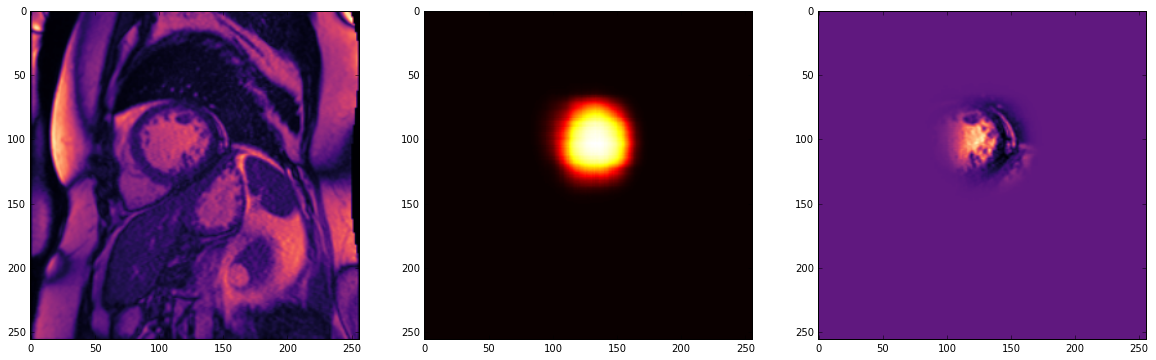

In [194]:
img = dicom.read_file('/home/leon/ML/kaggle/dsb/data/train/97/study/sax_10/IM-10982-0020.dcm').pixel_array
img = apply_per_slice_norm(crop_to_square(img, 256))

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img, cmap=plt.cm.magma)
plt.subplot(1,3,2)

segmentation = model.predict({'input': np.expand_dims(np.expand_dims(img, axis=0), axis=0)}, 
                             verbose=0)['output'][0,:,:]

plt.imshow(segmentation, cmap=plt.cm.hot)

plt.subplot(1,3,3)
plt.imshow(img * segmentation, cmap=plt.cm.magma)